In [70]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
# from qiskit_optimization.algorithms import COBYLA

import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn as sns
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt import plotting  # For plotting efficient frontier

### Create test stocks, calculate their statistics

In [73]:
"""
start_date = '2022-06-01' # inclusive
end_date = '2024-09-20' # exclusive
"""

budget = 100  # Example total investment (you can change this value)


# Example data (replace with actual prices)
data = pd.read_csv("close.csv", parse_dates=True, index_col="Date")

num_assets = len(data.columns)
print("Number of Assets followed:", num_assets)


# Calculate expected returns and sample covariance
mu = np.array(expected_returns.mean_historical_return(data))
sigma = np.array(risk_models.sample_cov(data))

# print(len(mu), len(sigma))

# sigma = risk_models.CovarianceShrinkage(data).ledoit_wolf()

Number of Assets followed: 21
False


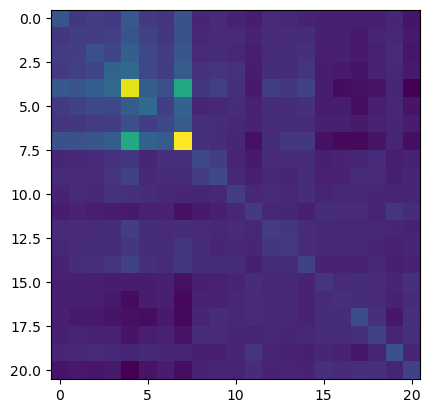

In [51]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

### formulate Portfolio Optimization (PO) problem

In [54]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()

### helper function for pretty output

In [57]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## Classical solution with NumPyMinimumEigensolver

In [60]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.], value -6.6093

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1]	-6.6093		1.0000


## Quantum solution with QAOA

In [64]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.], value -5.5645

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0]	-0.9222		0.0107
[0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0]	-2.7184		0.0098
[0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1]	-3.5975		0.0059
[1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1]	-2.9588		0.0059
[0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0]	-2.7247		0.0049
[0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0]	-0.9167		0.0049
[0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1]	-3.8943		0.0049
[0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0]	-0.7067		0.0049
[0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0]	-3.0231		0.0049
[0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1]	-2.0878		0.0039
[0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0]	-1.2841		0.0039
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1]	-4.3217		0.0039
[1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0]	-2.